In [1]:
!pip install neuralprophet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 145.8/145.8 kB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.9/79.9 MB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 21.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 815.2/815.2 kB 21.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 866.2/866.2 kB 14.9 MB/s eta 0:00:00


In [2]:
from neuralprophet import NeuralProphet

ERROR:NP.plotly:Importing plotly failed. Interactive plots will not work.
ERROR:NP.plotly:Importing plotly failed. Interactive plots will not work.


In [3]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import drive
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.cluster import KMeans
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import os

In [4]:
# Mount Google Drive
drive.mount('/content/drive')

# Path of folder
folder_path = '/content/drive/MyDrive/Colab Notebooks/2024_08_27 Neural prophet main model/'

# Get list of all CSV files in the folder
csv_files = [os.path.join(folder_path, file) for file in os.listdir(folder_path) if file.endswith('.csv')]

# Initialize an empty list to hold the dataframes
dfs = []

# Loop through the CSV files and read each one into a dataframe
for file in csv_files:
    df = pd.read_csv(file)
    dfs.append(df)

# Concatenate all dataframes into a single dataframe
data = pd.concat(dfs, ignore_index=True)

Mounted at /content/drive


In [5]:
data_selected = data[['Alarm Name', 'Alarm Location Info', 'First Occurred On', 'Site ID', 'Vendor', 'Domain', 'Device Type']]
data_selected.head(10)

,Alarm Name,Alarm Location Info,First Occurred On,Site ID,Vendor,Domain,Device Type
0,Air Conditioner Frequent High Pressure,NodeB IP:10.145.187.30; Site ID:AM0212; Kalmun...,2024-08-25 23:36:16,AM0212,HUAWEI,Power,NaN
1,Air Conditioner Frequent High Pressure,NodeB IP:10.145.187.30; Site ID:AM0212; Kalmun...,2024-08-25 22:27:09,AM0212,HUAWEI,Power,NaN
2,Air Conditioner Frequent High Pressure,NodeB IP:10.145.187.30; Site ID:AM0212; Kalmun...,2024-08-25 21:19:01,AM0212,HUAWEI,Power,NaN
3,RF Unit TX Channel Gain Out of Range,"Cabinet No.=0, Subrack No.=132, Slot No.=0, TX...",2024-08-25 21:09:23,BA0002,HUAWEI,Access,GBTS
4,Air Conditioner Frequent High Pressure,NodeB IP:10.145.187.30; Site ID:AM0212; Kalmun...,2024-08-25 20:10:55,AM0212,HUAWEI,Power,NaN
5,RF Unit TX Channel Gain Out of Range,"Cabinet No.=0, Subrack No.=62, Slot No.=0, TX ...",2024-08-25 19:53:23,AM0212,HUAWEI,Access,GBTS
6,Air Conditioner Frequent High Pressure,NodeB IP:10.145.187.30; Site ID:AM0212; Kalmun...,2024-08-25 19:02:45,AM0212,HUAWEI,Power,NaN
7,No Solar Generation,Site ID:PU0062; Channnel IP:10.145.144.30; Nag...,2024-08-25 18:06:48,PU0062,HUAWEI,Power,NaN
8,Mains Failure Alarm,"Cabinet No.=0, Subrack No.=0, Slot No.=19, Por...",2024-08-25 18:04:27,PU0062,HUAWEI,Power,GBTS
9,AC Failure,NodeB IP:10.145.144.30; Site ID:PU0062; Nagawi...,2024-08-25 18:04:19,PU0062,HUAWEI,Power,NaN


In [6]:
# prompt: encode the Alarm name column  and rename that column as y

le = LabelEncoder()
data_selected['y'] = le.fit_transform(data_selected['Alarm Name'])
data_selected = data_selected.drop('Alarm Name', axis=1)
data_selected.head(10)

WARNING - (py.warnings._showwarnmsg) - <ipython-input-6-a9b895c87a75>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_selected['y'] = le.fit_transform(data_selected['Alarm Name'])

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_selected['y'] = le.fit_transform(data_selected['Alarm Name'])



,Alarm Location Info,First Occurred On,Site ID,Vendor,Domain,Device Type,y
0,NodeB IP:10.145.187.30; Site ID:AM0212; Kalmun...,2024-08-25 23:36:16,AM0212,HUAWEI,Power,NaN,10
1,NodeB IP:10.145.187.30; Site ID:AM0212; Kalmun...,2024-08-25 22:27:09,AM0212,HUAWEI,Power,NaN,10
2,NodeB IP:10.145.187.30; Site ID:AM0212; Kalmun...,2024-08-25 21:19:01,AM0212,HUAWEI,Power,NaN,10
3,"Cabinet No.=0, Subrack No.=132, Slot No.=0, TX...",2024-08-25 21:09:23,BA0002,HUAWEI,Access,GBTS,156
4,NodeB IP:10.145.187.30; Site ID:AM0212; Kalmun...,2024-08-25 20:10:55,AM0212,HUAWEI,Power,NaN,10
5,"Cabinet No.=0, Subrack No.=62, Slot No.=0, TX ...",2024-08-25 19:53:23,AM0212,HUAWEI,Access,GBTS,156
6,NodeB IP:10.145.187.30; Site ID:AM0212; Kalmun...,2024-08-25 19:02:45,AM0212,HUAWEI,Power,NaN,10
7,Site ID:PU0062; Channnel IP:10.145.144.30; Nag...,2024-08-25 18:06:48,PU0062,HUAWEI,Power,NaN,124
8,"Cabinet No.=0, Subrack No.=0, Slot No.=19, Por...",2024-08-25 18:04:27,PU0062,HUAWEI,Power,GBTS,118
9,NodeB IP:10.145.144.30; Site ID:PU0062; Nagawi...,2024-08-25 18:04:19,PU0062,HUAWEI,Power,NaN,5


In [7]:
# prompt: give mapping of encoded value to alarm name  print line by line

for i, alarm_name in enumerate(le.classes_):
  print(f'{i}: {alarm_name}')

0:  Phase L3 Failure
1:  Phase L3 Under Voltage
2: (PTP)Time synchronization faulty--2501553
3: (Sync E)The state of clock source is failed--2600422
4: (Sync E)The work mode of system clock is not in locked mode--2600420
5: AC Failure
6: AM_DOWNSHIFT
7: AUTOLOOPDETECT
8: AVG Two way Packet Loss Ratio
9: Air Conditioner External Fan Fault
10: Air Conditioner Frequent High Pressure
11: Air Conditioner High Temperature
12: All Lithium Battery Communication Failure
13: All Rectifiers Communication Failure
14: Ambient Temperature Unacceptable
15: BB Discharge 95 percent DoD
16: BBU CPRI Interface Error
17: BBU CPRI Optical Module or Electrical Port Not Ready
18: BD_STATUS
19: BFD session down
20: BGP Status Changed
21: BLVD Disconnected
22: BMU Missing
23: BSS_GCell-Call_Setup_Suc_Rate_Cell_Huawei2G
24: BSS_GCell-H-Call_Drop_Rate_Trend_Huawei2G
25: BSS_LCell-UL_Avg_Tpt
26: BSS_LCell-eRAB_Drop_Rate
27: BSS_LCell_QCI1_eRAB_Suc_Rate
28: BUS_ERR
29: Battery Deep Discharge Alarm
30: Battery Fuse

In [8]:
# prompt: save the label encoder for future use , and remember 'RF Unit TX Channel Gain Out of Range'  .It is the target alarm to forecast

import pickle

# Save the LabelEncoder
with open('label_encoder.pkl', 'wb') as f:
  pickle.dump(le, f)

# Find the index for 'RF Unit TX Channel Gain Out of Range'
target_alarm_index = le.transform(['RF Unit TX Channel Gain Out of Range'])[0]
print(f"Target alarm index: {target_alarm_index}")


Target alarm index: 156


In [9]:
# prompt: rename first occured column as ds

data_selected = data_selected.rename(columns={'First Occurred On': 'ds'})
data_selected.head(10)


,Alarm Location Info,ds,Site ID,Vendor,Domain,Device Type,y
0,NodeB IP:10.145.187.30; Site ID:AM0212; Kalmun...,2024-08-25 23:36:16,AM0212,HUAWEI,Power,NaN,10
1,NodeB IP:10.145.187.30; Site ID:AM0212; Kalmun...,2024-08-25 22:27:09,AM0212,HUAWEI,Power,NaN,10
2,NodeB IP:10.145.187.30; Site ID:AM0212; Kalmun...,2024-08-25 21:19:01,AM0212,HUAWEI,Power,NaN,10
3,"Cabinet No.=0, Subrack No.=132, Slot No.=0, TX...",2024-08-25 21:09:23,BA0002,HUAWEI,Access,GBTS,156
4,NodeB IP:10.145.187.30; Site ID:AM0212; Kalmun...,2024-08-25 20:10:55,AM0212,HUAWEI,Power,NaN,10
5,"Cabinet No.=0, Subrack No.=62, Slot No.=0, TX ...",2024-08-25 19:53:23,AM0212,HUAWEI,Access,GBTS,156
6,NodeB IP:10.145.187.30; Site ID:AM0212; Kalmun...,2024-08-25 19:02:45,AM0212,HUAWEI,Power,NaN,10
7,Site ID:PU0062; Channnel IP:10.145.144.30; Nag...,2024-08-25 18:06:48,PU0062,HUAWEI,Power,NaN,124
8,"Cabinet No.=0, Subrack No.=0, Slot No.=19, Por...",2024-08-25 18:04:27,PU0062,HUAWEI,Power,GBTS,118
9,NodeB IP:10.145.144.30; Site ID:PU0062; Nagawi...,2024-08-25 18:04:19,PU0062,HUAWEI,Power,NaN,5


In [10]:
# prompt: sort accoding to ds column latest alarms

data_selected['ds'] = pd.to_datetime(data_selected['ds'])
data_selected = data_selected.sort_values(by='ds', ascending=False)
data_selected.head(10)

,Alarm Location Info,ds,Site ID,Vendor,Domain,Device Type,y
0,NodeB IP:10.145.187.30; Site ID:AM0212; Kalmun...,2024-08-25 23:36:16,AM0212,HUAWEI,Power,NaN,10
1,NodeB IP:10.145.187.30; Site ID:AM0212; Kalmun...,2024-08-25 22:27:09,AM0212,HUAWEI,Power,NaN,10
2,NodeB IP:10.145.187.30; Site ID:AM0212; Kalmun...,2024-08-25 21:19:01,AM0212,HUAWEI,Power,NaN,10
3,"Cabinet No.=0, Subrack No.=132, Slot No.=0, TX...",2024-08-25 21:09:23,BA0002,HUAWEI,Access,GBTS,156
4,NodeB IP:10.145.187.30; Site ID:AM0212; Kalmun...,2024-08-25 20:10:55,AM0212,HUAWEI,Power,NaN,10
5,"Cabinet No.=0, Subrack No.=62, Slot No.=0, TX ...",2024-08-25 19:53:23,AM0212,HUAWEI,Access,GBTS,156
6,NodeB IP:10.145.187.30; Site ID:AM0212; Kalmun...,2024-08-25 19:02:45,AM0212,HUAWEI,Power,NaN,10
7,Site ID:PU0062; Channnel IP:10.145.144.30; Nag...,2024-08-25 18:06:48,PU0062,HUAWEI,Power,NaN,124
8,"Cabinet No.=0, Subrack No.=0, Slot No.=19, Por...",2024-08-25 18:04:27,PU0062,HUAWEI,Power,GBTS,118
9,NodeB IP:10.145.144.30; Site ID:PU0062; Nagawi...,2024-08-25 18:04:19,PU0062,HUAWEI,Power,NaN,5


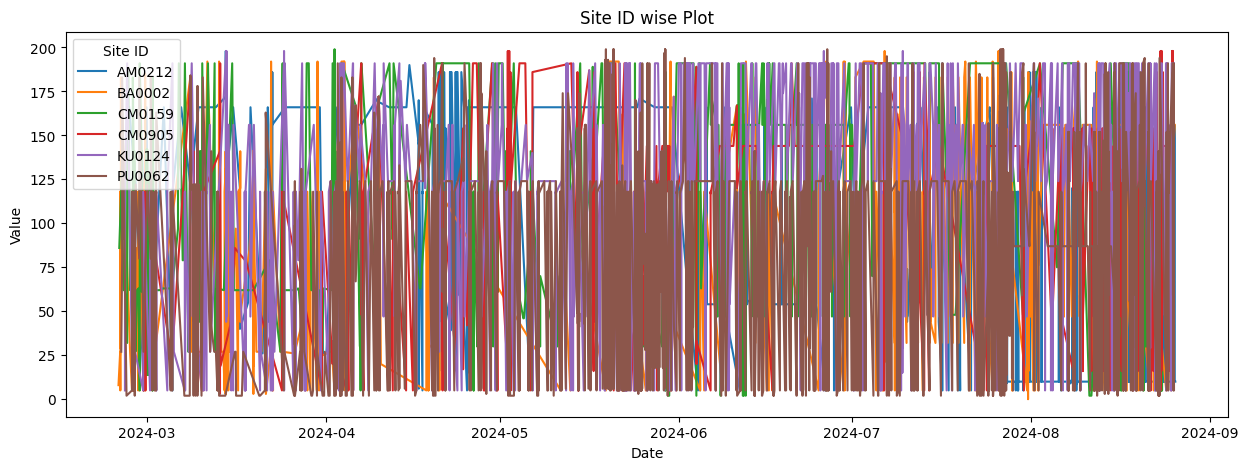

In [11]:
import pandas as pd
import matplotlib.pyplot as plt

# Plot grouped by Site ID
plt.figure(figsize=(15, 5))

for site_id, group_data in data_selected.groupby('Site ID'):
    plt.plot(group_data['ds'], group_data['y'], label=site_id)

plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Site ID wise Plot')
plt.legend(title='Site ID')
plt.show()

In [12]:

data_selected.head(10)

,Alarm Location Info,ds,Site ID,Vendor,Domain,Device Type,y
0,NodeB IP:10.145.187.30; Site ID:AM0212; Kalmun...,2024-08-25 23:36:16,AM0212,HUAWEI,Power,NaN,10
1,NodeB IP:10.145.187.30; Site ID:AM0212; Kalmun...,2024-08-25 22:27:09,AM0212,HUAWEI,Power,NaN,10
2,NodeB IP:10.145.187.30; Site ID:AM0212; Kalmun...,2024-08-25 21:19:01,AM0212,HUAWEI,Power,NaN,10
3,"Cabinet No.=0, Subrack No.=132, Slot No.=0, TX...",2024-08-25 21:09:23,BA0002,HUAWEI,Access,GBTS,156
4,NodeB IP:10.145.187.30; Site ID:AM0212; Kalmun...,2024-08-25 20:10:55,AM0212,HUAWEI,Power,NaN,10
5,"Cabinet No.=0, Subrack No.=62, Slot No.=0, TX ...",2024-08-25 19:53:23,AM0212,HUAWEI,Access,GBTS,156
6,NodeB IP:10.145.187.30; Site ID:AM0212; Kalmun...,2024-08-25 19:02:45,AM0212,HUAWEI,Power,NaN,10
7,Site ID:PU0062; Channnel IP:10.145.144.30; Nag...,2024-08-25 18:06:48,PU0062,HUAWEI,Power,NaN,124
8,"Cabinet No.=0, Subrack No.=0, Slot No.=19, Por...",2024-08-25 18:04:27,PU0062,HUAWEI,Power,GBTS,118
9,NodeB IP:10.145.144.30; Site ID:PU0062; Nagawi...,2024-08-25 18:04:19,PU0062,HUAWEI,Power,NaN,5


In [13]:
# prompt: drop rows with y is unknown

data_selected = data_selected[data_selected['y'] != 'Unknown']

In [14]:
# prompt: remove duplicates in ds

data_selected = data_selected.drop_duplicates(subset=['ds'])
data_selected.head(10)


,Alarm Location Info,ds,Site ID,Vendor,Domain,Device Type,y
0,NodeB IP:10.145.187.30; Site ID:AM0212; Kalmun...,2024-08-25 23:36:16,AM0212,HUAWEI,Power,NaN,10
1,NodeB IP:10.145.187.30; Site ID:AM0212; Kalmun...,2024-08-25 22:27:09,AM0212,HUAWEI,Power,NaN,10
2,NodeB IP:10.145.187.30; Site ID:AM0212; Kalmun...,2024-08-25 21:19:01,AM0212,HUAWEI,Power,NaN,10
3,"Cabinet No.=0, Subrack No.=132, Slot No.=0, TX...",2024-08-25 21:09:23,BA0002,HUAWEI,Access,GBTS,156
4,NodeB IP:10.145.187.30; Site ID:AM0212; Kalmun...,2024-08-25 20:10:55,AM0212,HUAWEI,Power,NaN,10
5,"Cabinet No.=0, Subrack No.=62, Slot No.=0, TX ...",2024-08-25 19:53:23,AM0212,HUAWEI,Access,GBTS,156
6,NodeB IP:10.145.187.30; Site ID:AM0212; Kalmun...,2024-08-25 19:02:45,AM0212,HUAWEI,Power,NaN,10
7,Site ID:PU0062; Channnel IP:10.145.144.30; Nag...,2024-08-25 18:06:48,PU0062,HUAWEI,Power,NaN,124
8,"Cabinet No.=0, Subrack No.=0, Slot No.=19, Por...",2024-08-25 18:04:27,PU0062,HUAWEI,Power,GBTS,118
9,NodeB IP:10.145.144.30; Site ID:PU0062; Nagawi...,2024-08-25 18:04:19,PU0062,HUAWEI,Power,NaN,5


In [15]:


# Keep only 'ds' and 'y' columns (preprocessing for NeuralProphet)
data_selected = data_selected[['ds', 'y', 'Site ID']]
data_selected.head(10)


,ds,y,Site ID
0,2024-08-25 23:36:16,10,AM0212
1,2024-08-25 22:27:09,10,AM0212
2,2024-08-25 21:19:01,10,AM0212
3,2024-08-25 21:09:23,156,BA0002
4,2024-08-25 20:10:55,10,AM0212
5,2024-08-25 19:53:23,156,AM0212
6,2024-08-25 19:02:45,10,AM0212
7,2024-08-25 18:06:48,124,PU0062
8,2024-08-25 18:04:27,118,PU0062
9,2024-08-25 18:04:19,5,PU0062


In [16]:
# prompt: create seperate dataframes for each site id with ds and y columns

site_dfs = {}
for site_id, group_data in data_selected.groupby('Site ID'):
  site_dfs[site_id] = group_data[['ds', 'y']]


In [17]:
# prompt: target forecast alarm by using previous alarms before target alarm, for prediction is RF Unit TX Channel Gain Out of Range

# Assuming 'RF Unit TX Channel Gain Out of Range' is a specific value in the 'y' column
target_alarm = 156  # Replace with the actual value if different

# Create a dictionary to store forecasts for each site
forecasts = {}
# You can further analyze the forecasts to identify potential occurrences of the target alarm
# For example, check if the predicted 'y' values are close to the target_alarm value


In [18]:
# prompt:  Create a NeuralProphet model with default parameters

# Import the NeuralProphet class
from neuralprophet import NeuralProphet, set_log_level

# Disable logging messages unless there is an error
set_log_level("ERROR")

# Set the learning rate and define other hyperparameters directly
m = NeuralProphet(
    learning_rate=0.01,          # Set the learning rate to 0.005
    batch_size=32,
    seasonality_mode='additive',  # Seasonality mode (choose between 'additive' or 'multiplicative')
)

# Use static plotly in notebooks
m.set_plotting_backend("plotly-static")

In [19]:

# from neuralprophet import NeuralProphet

# # Define function to train and forecast using NeuralProphet
# def train_and_forecast(site_df, target_alarm, periods=7):
#     # Initialize the NeuralProphet model
#     model = NeuralProphet(yearly_seasonality=False, weekly_seasonality=True, daily_seasonality=False)

#     # Rename columns to fit NeuralProphet format
#     site_df = site_df.rename(columns={'ds': 'ds', 'y': 'y'})

#     # Train the model
#     model.fit(site_df, freq='D')

#     # Forecast the next 'periods' days
#     future = model.make_future_dataframe(site_df, periods=periods)
#     forecast = model.predict(future)

#     return forecast

# # Create a dictionary to store forecasts for each site
# forecasts = {}
# for site_id, site_df in site_dfs.items():
#     forecasts[site_id] = train_and_forecast(site_df, target_alarm)

# # Function to forecast for new data
# def forecast_for_new_data(new_data, site_id, model_dict, target_alarm, periods=7):
#     if site_id in model_dict:
#         model = model_dict[site_id]
#     else:
#         # Handle cases where site_id is not in the trained models
#         raise ValueError(f"Model for site_id {site_id} not found.")

#     # Rename columns to fit NeuralProphet format
#     new_data = new_data.rename(columns={'ds': 'ds', 'y': 'y'})

#     # Forecast the next 'periods' days
#     future = model.make_future_dataframe(new_data, periods=periods)
#     forecast = model.predict(future)

#     return forecast

# # Example usage for a new dataset
# # new_site_data = pd.read_csv('path_to_new_site_data.csv')
# # new_site_data = new_site_data.rename(columns={'First Occurred On': 'ds', 'Alarm Name': 'y'})
# # forecast_results = forecast_for_new_data(new_site_data, 'site_id', forecasts, target_alarm)

# # You can now analyze forecast_results for your predictions
# # Plotting example for one site
# site_id = list(forecasts.keys())[0]  # Example: use the first site ID
# forecast = forecasts[site_id]

# plt.figure(figsize=(15, 5))
# plt.plot(forecast['ds'], forecast['yhat1'], label='Forecast')
# plt.axhline(y=target_alarm, color='r', linestyle='--', label='Target Alarm Threshold')
# plt.xlabel('Date')
# plt.ylabel('Value')
# plt.title(f'Forecast for Site ID {site_id}')
# plt.legend()
# plt.show()



In [20]:
from neuralprophet import NeuralProphet, set_log_level
import pandas as pd
import matplotlib.pyplot as plt
import pickle

# Set log level to error to reduce unnecessary log outputs
set_log_level("ERROR")

# Load the LabelEncoder
with open('label_encoder.pkl', 'rb') as f:
    le = pickle.load(f)

# Define target alarm index
target_alarm_index = le.transform(['RF Unit TX Channel Gain Out of Range'])[0]

# Function to build, train, and forecast using NeuralProphet
def train_and_forecast(site_df, periods=7):
    # Initialize the NeuralProphet model
    m = NeuralProphet(
        learning_rate=0.01,
        batch_size=32,
        seasonality_mode='additive'
    )

    # Fit the model
    m.fit(site_df, freq='D')

    # Create a future dataframe to forecast
    future = m.make_future_dataframe(site_df, periods=periods)
    forecast = m.predict(future)

    return forecast

# Create forecasts for each site
forecasts = {}
for site_id, site_df in site_dfs.items():
    forecasts[site_id] = train_and_forecast(site_df)

# Function to forecast for new data
def forecast_for_new_data(new_data, periods=7):
    # Initialize the NeuralProphet model
    m = NeuralProphet(
        learning_rate=0.01,
        batch_size=32,
        seasonality_mode='additive'
    )

    # Fit the model on the new data
    new_data = new_data.rename(columns={'ds': 'ds', 'y': 'y'})
    m.fit(new_data, freq='D')

    # Create a future dataframe to forecast
    future = m.make_future_dataframe(new_data, periods=periods)
    forecast = m.predict(future)

    return forecast

# Example usage for a specific site
site_id = 'example_site_id'  # Replace with the actual Site ID
if site_id in forecasts:
    forecast = forecasts[site_id]
    plt.figure(figsize=(15, 5))
    plt.plot(forecast['ds'], forecast['yhat1'], label='Forecast')
    plt.axhline(y=target_alarm_index, color='r', linestyle='--', label='Target Alarm Threshold')
    plt.xlabel('Date')
    plt.ylabel('Value')
    plt.title(f'Forecast for Site ID {site_id}')
    plt.legend()
    plt.show()

# Example usage for new dataset
# new_site_data = pd.read_csv('path_to_new_site_data.csv')
# new_site_data = new_site_data.rename(columns={'First Occurred On': 'ds', 'Alarm Name': 'y'})
# new_forecast = forecast_for_new_data(new_site_data)
# plt.figure(figsize=(15, 5))
# plt.plot(new_forecast['ds'], new_forecast['yhat1'], label='New Data Forecast')
# plt.axhline(y=target_alarm_index, color='r', linestyle='--', label='Target Alarm Threshold')
# plt.xlabel('Date')
# plt.ylabel('Value')
# plt.title('Forecast for New Data')
# plt.legend()
# plt.show()


Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /usr/local/lib/python3.10/dist-packages/pytorch_lightning/utilities/data.py:78: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 32. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.


WARNING - (py.warnings._showwarnmsg) - /usr/local/lib/python3.10/dist-packages/pytorch_lightning/utilities/data.py:78: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 29. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.




Predicting: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /usr/local/lib/python3.10/dist-packages/pytorch_lightning/utilities/data.py:78: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 8. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.




Predicting: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /usr/local/lib/python3.10/dist-packages/pytorch_lightning/utilities/data.py:78: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 20. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.




Predicting: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /usr/local/lib/python3.10/dist-packages/pytorch_lightning/utilities/data.py:78: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 19. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.




Predicting: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /usr/local/lib/python3.10/dist-packages/pytorch_lightning/utilities/data.py:78: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 3. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.




Predicting: |          | 0/? [00:00<?, ?it/s]

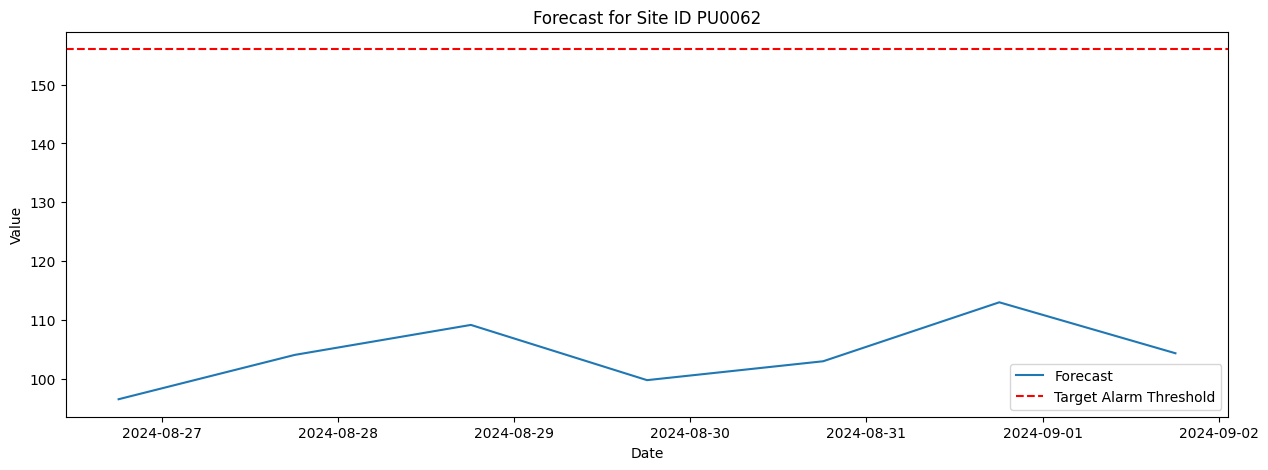

In [21]:

# Example usage for a specific site
site_id = 'PU0062'  # Replace with the actual Site ID
if site_id in forecasts:
    forecast = forecasts[site_id]
    plt.figure(figsize=(15, 5))
    plt.plot(forecast['ds'], forecast['yhat1'], label='Forecast')
    plt.axhline(y=target_alarm_index, color='r', linestyle='--', label='Target Alarm Threshold')
    plt.xlabel('Date')
    plt.ylabel('Value')
    plt.title(f'Forecast for Site ID {site_id}')
    plt.legend()
    plt.show()

In [22]:
# Function to calculate accuracy based on the target alarm
def calculate_accuracy(forecast, actual_df, margin=0.5):
    # Get the predicted values close to the target alarm index
    predicted_close = (np.abs(forecast['yhat1'] - target_alarm_index) <= margin)

    # Check if the target alarm actually occurred
    actual_occurred = (np.abs(actual_df['y'] - target_alarm_index) <= margin)

    # Calculate accuracy as the percentage of correct predictions
    accuracy = (predicted_close == actual_occurred).mean() * 100

    return accuracy

# Create forecasts and calculate accuracy for each site
forecasts = {}
accuracies = {}
for site_id, site_df in site_dfs.items():
    # Forecast
    forecasts[site_id] = train_and_forecast(site_df)

    # Calculate accuracy using the last 7 days of actual data for comparison
    accuracy = calculate_accuracy(forecasts[site_id].iloc[-7:], site_df.iloc[-7:])
    accuracies[site_id] = accuracy
    print(f'Accuracy for Site ID {site_id}: {accuracy:.2f}%')

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

ValueError: Can only compare identically-labeled Series objects

In [23]:
# Example usage for new dataset
new_site_data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/2024_08_27 Neural prophet main model/')
new_site_data = new_site_data.rename(columns={'First Occurred On': 'ds', 'Alarm Name': 'y'})
new_forecast = forecast_for_new_data(new_site_data)
plt.figure(figsize=(15, 5))
plt.plot(new_forecast['ds'], new_forecast['yhat1'], label='New Data Forecast')
plt.axhline(y=target_alarm_index, color='r', linestyle='--', label='Target Alarm Threshold')
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Forecast for New Data')
plt.legend()
plt.show()

IsADirectoryError: [Errno 21] Is a directory: '/content/drive/MyDrive/Colab Notebooks/2024_08_27 Neural prophet main model/'

In [ ]:
# prompt: plot the forecast for other 5 remaining sites also

# Plotting for the remaining 5 sites
for site_id in list(forecasts.keys())[1:6]:  # Get the next 5 site IDs
    forecast = forecasts[site_id]

    plt.figure(figsize=(15, 5))
    plt.plot(forecast['ds'], forecast['yhat1'], label='Forecast')
    plt.axhline(y=target_alarm, color='r', linestyle='--', label='Target Alarm Threshold')
    plt.xlabel('Date')
    plt.ylabel('Value')
    plt.title(f'Forecast for Site ID {site_id}')
    plt.legend()
    plt.show()


In [ ]:
# prompt: print the all forecasts for all sites with their actual alarm names

# Load the LabelEncoder
with open('label_encoder.pkl', 'rb') as f:
  le = pickle.load(f)

for site_id, forecast in forecasts.items():
  print(f'Site ID: {site_id}')

  # Convert the encoded alarm values back to their original names
  forecast['alarm_name'] = le.inverse_transform(forecast['yhat1'].astype(int))

  print(forecast[['ds', 'alarm_name', 'yhat1']])
  print('-' * 50)


In [ ]:
# prompt: print th e forecast above

# Assuming 'forecast' variable holds the forecast DataFrame from the previous code

print(forecast)


In [ ]:
# prompt: print the forecast with actual alarm names

# Load the LabelEncoder
with open('label_encoder.pkl', 'rb') as f:
  le = pickle.load(f)

# Assuming 'forecast' variable holds the forecast DataFrame
forecast['alarm_name'] = le.inverse_transform(forecast['yhat1'].astype(int))

print(forecast[['ds', 'yhat1', 'alarm_name']])


In [ ]:
# prompt: where those duplicate values

# Find duplicate rows based on all columns
duplicate_rows = data_selected[data_selected.duplicated(keep=False)]

# Print the duplicate rows
print(duplicate_rows)


In [ ]:
# Function to predict using the generalized model
def predict_with_generalized_model(input_data):
    input_data['ds'] = pd.to_datetime(input_data['ds'])
     # Select only the 'y' column before resampling to avoid including 'Site ID'
    input_data = input_data.set_index('ds')[['y']].resample('H').mean().reset_index()

    # Combine forecasts from all models
    combined_forecast = pd.DataFrame()

    for model in models:
        # Create a future dataframe reaching 24*7 into the future
        df_future = model.make_future_dataframe(input_data, n_historic_predictions=True, periods=24*7)

        # Predict the future
        forecast = model.predict(df_future)
        combined_forecast = pd.concat([combined_forecast, forecast[['ds', 'yhat1']]], axis=1)

    # Average the predictions across all models
    combined_forecast['yhat_mean'] = combined_forecast.filter(like='yhat1').mean(axis=1)

    return combined_forecast[['ds', 'yhat_mean']]


In [ ]:
# # Create a new dataframe reaching 24*7 into the future for our forecast, n_historic_predictions also shows historic data
# df_future = m.make_future_dataframe(PU0146_alarms, n_historic_predictions=True, periods=24*7)

# # Predict the future
# forecast = m.predict(df_future)

# # Visualize the forecast
# m.plot(forecast)
# List of site IDs you want to forecast for
site_ids = data_selected['Site ID'].unique()

# Loop through each site ID and generate forecasts
for site_id in site_ids:
    print(f"Forecasting for Site ID: {site_id}")

    # Filter the data for the specific site ID
    site_data = data_selected[data_selected['Site ID'] == site_id]

    # Example: Predict for the site dataset using the generalized model
    forecast = predict_with_generalized_model(site_data)

    # Plot the generalized forecast for the current site ID
    plt.figure(figsize=(15, 5))
    plt.plot(forecast['ds'], forecast['yhat_mean'], label=f'Generalized Forecast for Site {site_id}')
    plt.xlabel('Date')
    plt.ylabel('Value')
    plt.title(f'Generalized Forecast for Site ID {site_id}')
    plt.legend()
    plt.show()

In [ ]:
# prompt: now the model is fitted, so now  Create a new dataframe reaching 7 days into the future for our forecast for sit CM0159

# Filter data for site CM0159
site_data_CM0159 = data_selected[data_selected['Site ID'] == 'CM0159']

# Create a future dataframe reaching 7 days into the future
future_df_CM0159 = m.make_future_dataframe(site_data_CM0159, periods=24*7)


In [ ]:

# Create a future dataframe reaching 7 days into the future
future_df_CM0159 = m.make_future_dataframe(site_data_CM0159[['ds','y']], periods=24*7)

# Predict the future
forecast_CM0159 = m.predict(future_df_CM0159)

# Round predictions to the nearest positive integer
forecast_CM0159['yhat1'] = forecast_CM0159['yhat1'].round().clip(lower=0).astype(int)

# Plot 'yhat1' as dots on the forecast plot
plt.figure(figsize=(15, 7))  # Create a new figure with adjusted size
plt.scatter(forecast_CM0159['ds'], forecast_CM0159['yhat1'], color='red', label='Forecast (Rounded)')

# Add labels to data points (only label non-zero predictions)
for i, row in forecast_CM0159.iterrows():
    if row['yhat1'] > 0:
        plt.text(row['ds'], row['yhat1'], f'{row["yhat1"]}', fontsize=8, ha='right', va='bottom')

plt.xlabel('Date')
plt.ylabel('Rounded Forecast Value')
plt.title('Forecasted Alarms for Site ID CM0159')
plt.legend()
plt.grid(True)  # Add grid lines for better readability

# Set x-axis ticks to show all dates, rotate for better readability
plt.xticks(rotation=45, ha='right')

# Automatically set y-axis ticks based on data
plt.yticks()

plt.tight_layout()  # Adjust layout to prevent clipping
plt.show()  # Display the plot

In [ ]:
# prompt: print the forecast with date and actual alarm name

# Assuming 'forecast_CM0159' contains the forecasted data and 'le' is the LabelEncoder

# Create a new DataFrame to store the results
forecast_with_names = forecast_CM0159[['ds', 'yhat1']].copy()

# Reverse the label encoding to get the alarm names
forecast_with_names['Alarm Name'] = le.inverse_transform(forecast_with_names['yhat1'])

# Print the forecast with date and alarm name
print(forecast_with_names[['ds', 'Alarm Name']])


In [ ]:
# prompt: view all the dates and round forecast values on the axes

# Filter data for site CM0159
site_data_CM0159 = data_selected[data_selected['Site ID'] == 'CM0159']

# Create a future dataframe reaching 7 days into the future
future_df_CM0159 = m.make_future_dataframe(site_data_CM0159[['ds','y']], periods=24*7)

# Predict the future
forecast_CM0159 = m.predict(future_df_CM0159)

# Round predictions to the nearest positive integer
forecast_CM0159['yhat1'] = forecast_CM0159['yhat1'].round().clip(lower=0).astype(int)

# Plot 'yhat1' as dots on the forecast plot
plt.figure(figsize=(15, 7))
plt.scatter(forecast_CM0159['ds'], forecast_CM0159['yhat1'], color='red', label='Forecast (Rounded)')

# Add labels to data points (only label non-zero predictions)
for i, row in forecast_CM0159.iterrows():
    if row['yhat1'] > 0:
        plt.text(row['ds'], row['yhat1'], f'{row["yhat1"]}', fontsize=8, ha='right', va='bottom')

plt.xlabel('Date')
plt.ylabel('Rounded Forecast Value')
plt.title('Forecasted Alarms for Site ID CM0159')
plt.legend()
plt.grid(True)

# Set x-axis ticks to show all dates, rotate for better readability
plt.xticks(forecast_CM0159['ds'], rotation=45, ha='right')

# Automatically set y-axis ticks based on data
plt.yticks(np.arange(min(forecast_CM0159['yhat1']), max(forecast_CM0159['yhat1'])+1, 1.0))

plt.tight_layout()
plt.show()


In [ ]:
# Create a new dataframe reaching 7 days into the future for our forecast
df_future = m.make_future_dataframe(PU0146_alarms, n_historic_predictions=True, periods=24*7)

# Predict the future
forecast = m.predict(df_future)

import matplotlib.pyplot as plt

# Round predictions to the nearest integer
forecast['yhat1'] = forecast['yhat1'].round().astype(int)

# Extract the date from the datetime
forecast['date'] = forecast['ds'].dt.date

# No limit applied, include all predictions
daily_predictions = forecast.reset_index(drop=True)

# Plot 'yhat' as dots on top of the existing plot
plt.figure(figsize=(15, 7))  # Create a new figure with adjusted size
plt.scatter(daily_predictions['ds'], daily_predictions['yhat1'], color='red', label='yhat forecast')

# Add labels to data points
for i, row in daily_predictions.iterrows():
    plt.text(row['ds'], row['yhat1'], f'{row["yhat1"]}', fontsize=8, ha='right', va='bottom')

plt.xlabel('Date')
plt.ylabel('yhat')
plt.title('Forecasted Alarms')
plt.legend()
plt.grid(True)  # Add grid lines for better readability

# Set x-axis ticks to show all dates, rotate for better readability
plt.xticks(rotation=45, ha='right')

# Automatically set y-axis ticks based on data
plt.yticks()

plt.tight_layout()  # Adjust layout to prevent clipping
plt.show()  # Display the plot

In [ ]:
# prompt: in next 7 days the alarm 21 will come or not ?

# Check if alarm 21 is predicted in the next 7 days
alarm_21_predicted = daily_predictions[daily_predictions["yhat1"] == 21]

if alarm_21_predicted.empty:
  print("Alarm 21 is NOT predicted to occur in the next 7 days.")
else:
  print("Alarm 21 IS predicted to occur in the next 7 days.")



In [ ]:
# prompt: print the forecast alarms around value 13  with the date, print only the data after the latest day of initial data

# Filter forecast for alarms around value 13
filtered_forecast = forecast[(forecast['yhat1'] == 21)]

# # Get the latest date in the original data
# last_date = PU0146_alarms['ds'].max()

# # Filter for dates after the last date in the original data
# filtered_forecast = filtered_forecast[filtered_forecast['ds'] > last_date]

# Filter for dates after 2024-08-24 12:00:00
filtered_forecast = filtered_forecast[filtered_forecast['ds'] > pd.to_datetime('2024-08-24 12:00:00')]

# Print the filtered forecast with date and yhat1
for index, row in filtered_forecast.iterrows():
  print(f"Date: {row['ds']}, Alarm (yhat1): {row['yhat1']:.2f}")


In [ ]:
# prompt: for above output print unique alarm per day

# Group by date and get the unique alarm values
unique_alarms_per_day = filtered_forecast.groupby('date')['yhat1'].unique()

# Print the unique alarms for each day
for date, alarms in unique_alarms_per_day.items():
    print(f"Date: {date}, Unique Alarms: {alarms}")

In [ ]:
# prompt: view the label encoders used

for i, alarm_name in enumerate(le.classes_):
  print(f'{i}: {alarm_name}')


In [ ]:
# Import necessary libraries
import matplotlib.pyplot as plt

# Limit to 2 or 3 alarms per day
forecast['date'] = forecast['ds'].dt.date  # Extract the date from the datetime
daily_predictions = forecast.groupby('date').apply(lambda x: x.nlargest(10, 'yhat1')).reset_index(drop=True)

# Create a new figure with adjusted size
fig, ax = plt.subplots(figsize=(55, 25))

# Plot 'yhat1' as dots on top of the existing plot
ax.scatter(daily_predictions['ds'], daily_predictions['yhat1'], color='red', label='yhat1 forecast')

# Add labels to data points
for i, row in daily_predictions.iterrows():
    ax.text(row['ds'], row['yhat1'], f'{row["yhat1"]:.2f}', fontsize=9, ha='right', va='bottom')

ax.set_xlabel('Date')
ax.set_ylabel('yhat1')
ax.set_title('Top 2 or 3 Alarms per Day')
ax.legend()
ax.grid(True)  # Add grid lines for better readability

# Set x-axis ticks to show all dates
plt.xticks(daily_predictions['ds'], rotation=45, ha='right')

# Set y-axis ticks to show all yhat1 values
plt.yticks(daily_predictions['yhat1'])

plt.tight_layout()  # Adjust layout to prevent clipping
plt.show()  # Display the plot